In [1]:
import netCDF4 as nc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import openpyxl

In [2]:
prcp1930 = nc.Dataset('D:/DaymetCH/ch_prcp_1930-2018_m_ch1903.nc4')
tave1930 = nc.Dataset('D:/DaymetCH/ch_tave_1930-2018_m_ch1903.nc4')
prcp2019 =  nc.Dataset('D:/DaymetCH/ch_prcp_2019_m_ch1903.nc4')
prcp2020 =  nc.Dataset('D:/DaymetCH/ch_prcp_2020_m_ch1903.nc4')
tave2019 =  nc.Dataset('D:/DaymetCH/ch_tave_2019_m_ch1903.nc4')
tave2020 =  nc.Dataset('D:/DaymetCH/ch_tave_2020_m_ch1903.nc4')

Some functions to get data ; beware that some of them rely on comparisons between sheets

In [72]:
# call period example = 'LFI4'.
def get_coordinates(period=str,file=str):
    data = pd.read_excel(file,sheet_name=period) 
    x = data['X']/1000 +650 # coordinates are not centered at y/x=600/200 on Bern as they should be, but y/x=1250/1250
    y = data['Y']/1000 +1050 
    month = data['DATUMF'].dt.month
    year = data['DATUMF'].dt.year
    new_year = (year-1929)*12
    new_date = new_year - 12 + month - 1 #index in python starts at 0
    df = new_date,x,y
    return pd.DataFrame(df).astype(int)

In [237]:
dataplot = get_coordinates('LFI3','NFI_data/PLOTDATEN.xlsx')
dataplot

,0,1,2,3,4,5,6,7,8,9,...,2393,2394,2395,2396,2397,2398,2399,2400,2401,2402
DATUMF,910,909,897,897,897,897,897,897,903,898,...,915,916,915,915,916,915,915,915,915,915
X,1338,1339,1370,1367,1373,1376,1357,1376,1329,1364,...,1377,1370,1372,1374,1369,1371,1373,1372,1374,1375
Y,1343,1338,1331,1330,1330,1329,1328,1321,1320,1319,...,1134,1133,1133,1133,1132,1132,1132,1131,1131,1130


In [5]:
def selected_time(time_coords,file):
    d_time = file.variables['time'][time_coords]
    time_unit = file.variables["time"].getncattr('units')
    time_cal = file.variables["time"].getncattr('calendar')
    local_time = nc.num2date(d_time, units=time_unit, calendar=time_cal) 
    return "Selected time : %s" % (local_time)

In [6]:
selected_time(dataplot[0][0],prcp1930) #first slicing : column for first plot. second slicing : first element, time

'Selected time : 1994-10-31 00:00:00'

These functions output the sum of precipitations and average temperature between two data collection campaigns (LFI1, LFI2, LFI3, LFI4).
This will not work properly if you selected LFI1 in previous functions above.

In [7]:
def get_prcp_plot(line,data):
    prcp1930.set_auto_maskandscale(False)   
    month = data['DATUMF'].dt.month
    year = data['DATUMF'].dt.year
    old_year = (year-1929)*12
    old_date = old_year - 12 + month - 1
    date = dataplot[line][0]
    x = dataplot[line][1]
    y = dataplot[line][2]
    current = prcp1930['prcp'][date,y,x]
    old_to_current = prcp1930['prcp'][old_date[line]:date,x,y]
    return round(sum(old_to_current),4),current


def get_tave_plot(line,data):
    tave1930.set_auto_maskandscale(False)     
    month = data['DATUMF'].dt.month
    year = data['DATUMF'].dt.year
    old_year = (year-1929)*12
    old_date = old_year - 12 + month - 1
    date = dataplot[line][0]
    y = dataplot[line][1]
    x = dataplot[line][2]
    current = tave1930['tave'][date,y,x]
    old_to_current = tave1930['tave'][old_date[line]:date,x,y]
    return round(np.mean(old_to_current),4),current


In [10]:
tave1930.set_auto_mask(False)
prcp1930.set_auto_mask(False)

In [238]:
previous = pd.read_excel('NFI_data/PLOTDATEN.xlsx',sheet_name='LFI2') #use previous sheet 

get_prcp_plot(620,previous)

(1317.2623, 8.900001)

In [19]:
prcp_append = []
for i in range(len(dataplot.columns)):
    prcp_append.append(get_prcp_plot(i,previous))

In [20]:
prcp_xls = pd.DataFrame(prcp_append,columns=['PRCP_SUM','PRCP'])
prcp_xls.to_excel('prcp_lf3-4.xlsx')

In [12]:
get_tave_plot(620,previous)

(8.5976, 14.33871)

In [21]:
tave_append = []
for i in range(len(dataplot.columns)):
    tave_append.append(get_tave_plot(i,previous))

In [22]:
tave_xls = pd.DataFrame(tave_append,columns=['TAVE_AVG','TAVE'])
tave_xls.to_excel('tave_lf3-4.xlsx')

In [270]:
def select_weather_growth_months(line,data,file,kind):
    file.set_auto_maskandscale(False)   
    month = data['DATUMF'].dt.month
    year = data['DATUMF'].dt.year
    old_year = (year-1929)*12
    old_date = old_year - 12 + month - 1
    date = dataplot[line][0]
    x = dataplot[line][1]
    y = dataplot[line][2]
    interval_y = int(((date - old_year)/12)[0])
    interval_1 = []
    interval_2 = []
    prcp_result = []
    tave_result = []
    for i in range(interval_y):
        interval_1.append(old_year[line]+(12*i+3))
        interval_2.append(old_year[line]+(12*i+8))
        prcp_result.append(np.sum(file[kind][interval_1[i]:interval_2[i],x,y]))
        tave_result.append(np.mean(file[kind][interval_1[i]:interval_2[i],x,y]))
    if kind == 'prcp':
        return sum(prcp_result)
    elif kind == 'tave':
        return np.mean(tave_result)
    
#example : select_weather_growth_months(0,previous,prcp1930,'prcp')

In [271]:
select_weather_growth_months(0,previous,tave1930,'tave')

14.4168625

In [272]:
select_weather_growth_months(0,previous,prcp1930,'prcp')

599.9468307495117

In [289]:
dataplot = get_coordinates('LFI4')
previous = pd.read_excel('NFI_data/PLOTDATEN.xlsx',sheet_name='LFI3')

In [290]:
prcp_growth_append = []
for i in range(len(dataplot.columns)):
    prcp_growth_append.append(select_weather_growth_months(i,previous,prcp1930,'prcp'))

In [291]:
df_prcp = pd.read_excel("prcp_lf3-4.xlsx").drop('Unnamed: 0',axis=1)

In [292]:
df_prcp['PRCP_GROWTH'] = prcp_growth_append
df_prcp.to_excel('prcp_lf3-4.xlsx')

In [293]:
tave_growth_append = []
for i in range(len(dataplot.columns)):
    tave_growth_append.append(select_weather_growth_months(i,previous,tave1930,'tave'))

In [294]:
df_tave = pd.read_excel("tave_lf3-4.xlsx").drop('Unnamed: 0',axis=1)

In [295]:
df_tave['TAVE_GROWTH'] = tave_growth_append
df_tave.to_excel('tave_lf3-4.xlsx')

In [180]:
def plot_image(meteo,file,kind):
    if kind == 'prcp':
        palette = 'viridis'
        label = 'Precipitations in cm'
    elif kind == 'tave':
        palette = 'magma'
        label = 'Temperature average in C°'
    d_time = file.variables['time'][meteo]
    time_unit = file.variables["time"].getncattr('units')
    month = nc.num2date(d_time,units=time_unit).month
    year = nc.num2date(d_time,units=time_unit).year
    plt.figure(figsize=(12,12))
    plt.axis('off')
    plt.imshow(file[kind][meteo],origin='lower',cmap=palette)
    #plt.gcf().set_facecolor("white")
    plt.colorbar(orientation='horizontal',fraction=0.025,label=label) 
    plt.title(f"{label} for month {month} of year {year}")
    plt.show()

In [183]:
tave1930.set_auto_maskandscale(True)
prcp1930.set_auto_maskandscale(True)
# this has to be reactivated to plot maps

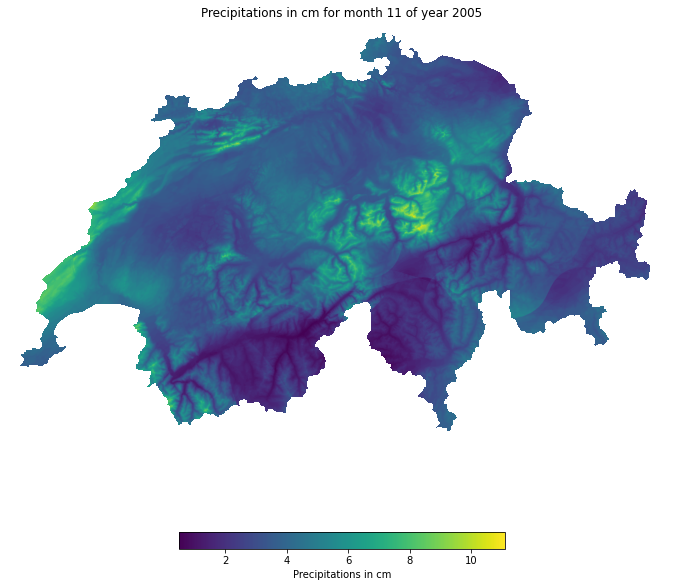

In [117]:
plot_image(dataplot[0][0],prcp1930,'prcp')

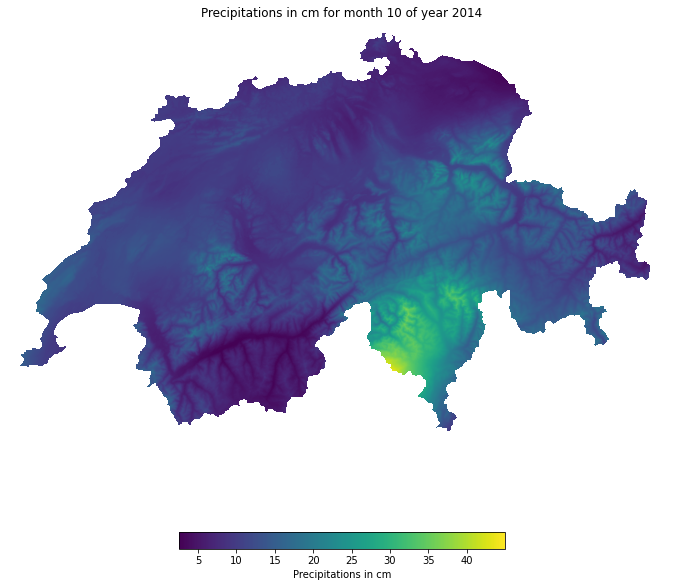

In [186]:
plot_image(dataplot[4][0],prcp1930,'prcp')

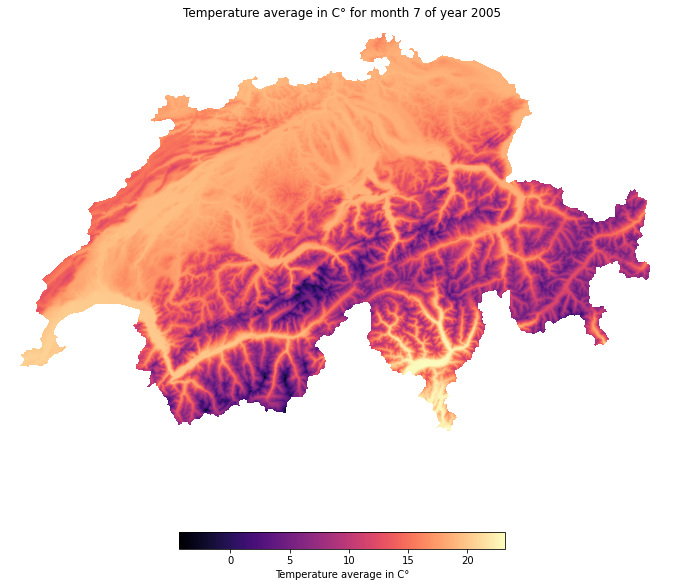

In [124]:
plot_image(906,tave1930,'tave')